In [72]:
import sys
import os
sys.path.append('../') # root directory

In [73]:
import read.JsonFileReader as json_reader
import matplotlib.pyplot as plt
from constants import constant
import pandas as pd
import numpy as np
import yfinance as yf

In [5]:
EMPTY = chr(8212)
EIDO_STATS = '../output/gold/EIDO_2020-08-20005340455384.json'
EIDO_HOLDINGS = '../input/archive/EIDO_Holdings.csv'

In [6]:
stocks = json_reader.parse(EIDO_STATS)
eido_df = pd.read_csv(EIDO_HOLDINGS)
print(f'Len(stocks): {len(stocks)}, \nEIDO holdings shape: {eido_df.shape}')
all_stat_names = [stat['name'] for key in ('financeStats', 'keyStats') for stat in stocks[0][key]]

Len(stocks): 74, 
EIDO holdings shape: (74, 6)


In [8]:
# TODO deal with statNames order

In [9]:
def getrow(stock, stat_names, periods='all', keys=('financeStats', 'keyStats')):
    stats = [stat for key in keys for stat in stock[key] if stat['name'] in stat_names]
    stat_values = [v['value'] for stat in stats for v in stat['values'] if periods == 'all' or v['period'] in periods]
    return [stock['symbol']] + stat_values

In [10]:
def extract_stat(stocks, stat_names, periods='all', keys=('financeStats', 'keyStats')):
    stats = [getrow(stock, stat_names, periods, keys) for stock in stocks]
    colheaders = pd.MultiIndex.from_product([stat_names, periods]).insert(0, 'Symbol')
    stats_df = pd.DataFrame(stats, columns=colheaders)
    stats_df = stats_df.replace(EMPTY, np.NaN)
    stats_df.loc[:, stat_names] = stats_df.loc[:, stat_names].astype('float32')
    return stats_df

In [97]:
def get_price(ticker, suffix='JK', period=-1): 
    symbol = f'{ticker}.{suffix}'
    stock = yf.Ticker(symbol)
    hist = stock.history(period="max")
    return hist['Close'][period]

In [114]:
unlisted = ['SIAP', 'INVS']
# for symbol in eido['Symbol']:
#     try:
#         get_price(symbol)
#     except Exception:
#         print('Exception for ', symbol)

In [11]:
stat_names = ['Earnings Per Share']
keys = ('financeStats',)
periods = ['2015-12', '2016-12', '2017-12', '2018-12', '2019-12', 'TTM']

In [12]:
stats_df = extract_stat(stocks, stat_names, periods, keys=keys)

/Users/vidurpuliani/opt/anaconda3/envs/dantone/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


In [126]:
eido = pd.merge(eido_df, stats_df, on='Symbol', how='left')
eido.index = eido['Symbol']
eido = eido.loc[eido['Weight'] >0, :] # unlisted [SIAP, INVS, SUGI]
eido['weightedEPS'] = eido['Weight'] * eido[('Earnings Per Share', 'TTM')]
eido['Price'] = eido['Symbol'].apply(get_price)

/Users/vidurpuliani/opt/anaconda3/envs/dantone/lib/python3.7/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/Users/vidurpuliani/opt/anaconda3/envs/dantone/lib/python3.7/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [133]:
eidoEPSList = []
for col in eido.columns[-8:-2]:
    weightedEPS = eido['Weight'] * eido[col]
    totalEPS = weightedEPS.fillna(0).sum()
    eidoEPSList.append(totalEPS)
    na_weight = eido.loc[eido[col].isna(), 'Weight'].sum()
    print(f'Total EPS for {col}: {totalEPS}. NA weight:{na_weight:0.2f}%')
eidoEPS = pd.Series(data=eidoEPSList, index=eido.columns[-8:-2])

Total EPS for ('Earnings Per Share', '2015-12'): 37027.286924865206. NA weight:4.01%
Total EPS for ('Earnings Per Share', '2016-12'): 40756.497078834866. NA weight:2.92%
Total EPS for ('Earnings Per Share', '2017-12'): 45254.87746621996. NA weight:1.90%
Total EPS for ('Earnings Per Share', '2018-12'): 49669.34030472184. NA weight:2.52%
Total EPS for ('Earnings Per Share', '2019-12'): 55367.45050997239. NA weight:3.57%
Total EPS for ('Earnings Per Share', 'TTM'): 54088.80141877472. NA weight:4.03%


<AxesSubplot:>

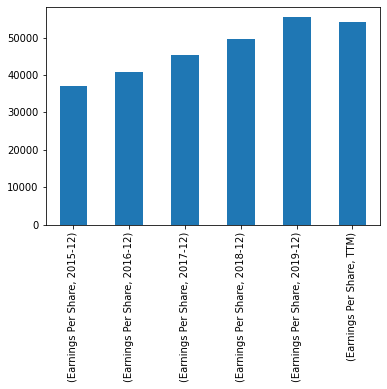

In [136]:
eidoEPS.plot(kind='bar')

<AxesSubplot:>

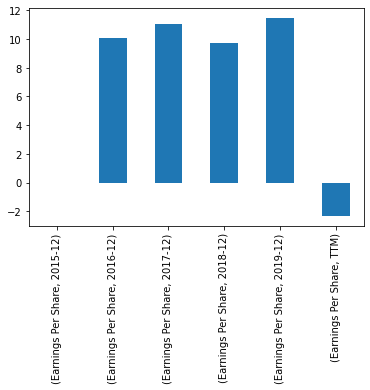

In [135]:
(eidoEPS.pct_change()*100).plot(kind='bar')

In [147]:
eido[('PE', 'TTM')] = (eido['Price']/eido[('Earnings Per Share', 'TTM')])

In [161]:
eido['weightedPE'] = (eido['Weight']/100) * eido[('PE', 'TTM')]

In [172]:
eido.sort_values('weightedPE', ascending=False)

,Symbol,Name,Sector,Asset,MarketCap,Weight,"(Earnings Per Share, 2015-12)","(Earnings Per Share, 2016-12)","(Earnings Per Share, 2017-12)","(Earnings Per Share, 2018-12)","(Earnings Per Share, 2019-12)","(Earnings Per Share, TTM)",weightedEPS,Price,"(PE, TTM)",weightedPE
Symbol,,,,,,,,,,,,,,,,
INKP,INKP,INDAH KIAT PULP & PAPER,Materials,Equity,"6,264,192.05",2.02,0.040000,0.040000,0.08,0.11,0.05,0.06,0.1212,9500.0,158333.336872,3198.333405
ADRO,ADRO,ADARO ENERGY TBK,Energy,Equity,"3,767,412.49",1.22,NaN,0.010000,0.01,0.01,0.01,0.01,0.0122,1115.0,111500.002492,1360.300030
TKIM,TKIM,PABRIK KERTAS TJIWI KIMIA,Materials,Equity,"2,508,082.23",0.81,NaN,NaN,0.01,0.08,0.05,0.05,0.0405,6925.0,138499.997936,1121.849983
ITMG,ITMG,INDO TAMBANGRAYA MEGAH,Energy,Equity,"1,016,134.52",0.33,0.060000,0.120000,0.23,0.24,0.12,0.09,0.0297,8200.0,91111.107491,300.666655
BBCA,BBCA,BANK CENTRAL ASIA,Financials,Equity,"59,178,550.05",19.10,731.000000,836.000000,945.00,1049.00,1159.00,1133.00,21640.3000,31650.0,27.934687,5.335525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MYRX,MYRX,HANSON INTERNATIONAL,Real Estate,Equity,"886,010.24",0.29,0.260000,0.870000,-1.53,1.10,-2.64,NaN,NaN,50.0,NaN,NaN
TRAM,TRAM,TRADA ALAM MINERA,Industrials,Equity,"392,497.91",0.13,-105.510002,-23.299999,-0.67,5.95,3.48,NaN,NaN,50.0,NaN,NaN
TAMU,TAMU,PELAYARAN TAMARIN SAMUDRA,Energy,Equity,"271,317.93",0.09,NaN,-2.270000,NaN,NaN,NaN,NaN,NaN,54.0,NaN,NaN


In [45]:
'http://financials.morningstar.com/ajax/ReportProcess4HtmlAjax.html?&t=XIDX:BBCA&region=idn&culture=en-US&version=SAL&cur=&reportType=is&period=12&dataType=R&order=asc&columnYear=10&curYearPart=1st5year&rounding=3&view=decimal&r=401953&callback=jsonp1597682400046&_=1597682400090'

'http://financials.morningstar.com/ajax/ReportProcess4HtmlAjax.html?&t=XIDX:BBCA&region=idn&culture=en-US&version=SAL&cur=&reportType=is&period=12&dataType=R&order=asc&columnYear=10&curYearPart=1st5year&rounding=3&view=decimal&r=401953&callback=jsonp1597682400046&_=1597682400090'

In [46]:
'http://financials.morningstar.com/ajax/ReportProcess4HtmlAjax.html?&t=XNSE:PCJEWELLER&region=ind&culture=en-US&version=SAL&cur=&reportType=is&period=12&dataType=R&order=asc&columnYear=10&curYearPart=1st5year&rounding=3&view=decimal&r=515122&callback=jsonp1597682464958&_=1597682465025'

'http://financials.morningstar.com/ajax/ReportProcess4HtmlAjax.html?&t=XNSE:PCJEWELLER&region=ind&culture=en-US&version=SAL&cur=&reportType=is&period=12&dataType=R&order=asc&columnYear=10&curYearPart=1st5year&rounding=3&view=decimal&r=515122&callback=jsonp1597682464958&_=1597682465025'

In [47]:
'http://financials.morningstar.com/ajax/ReportProcess4HtmlAjax.html?&t=XNSE:PCJEWELLER&region=ind&culture=en-US&version=SAL&cur=&reportType=bs&period=12&dataType=R&order=asc&columnYear=10&curYearPart=1st5year&rounding=3&view=decimal&r=617433&callback=jsonp1597682521236&_=1597682521326'

'http://financials.morningstar.com/ajax/ReportProcess4HtmlAjax.html?&t=XNSE:PCJEWELLER&region=ind&culture=en-US&version=SAL&cur=&reportType=bs&period=12&dataType=R&order=asc&columnYear=10&curYearPart=1st5year&rounding=3&view=decimal&r=617433&callback=jsonp1597682521236&_=1597682521326'

ADR: false
columnYear: "10" or "5"
culture: "en-US"
dataType: "A"(As Reported), "R"(Restated)
order: "asc" or "desc"
period: "12" or "3"
reportType: "bs" or "is" or "cf"
rounding: "4", 1(original), 2(thousands), 3(millions), 4(billions)
userType: "S"
view: "raw" or "percentage" or "decimal"